# Проект: классификация

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing  import LabelEncoder, MinMaxScaler
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
import optuna
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# убираем все ненужные символы и преобразовываем из object в float
df['balance'] = df['balance'].str.replace(',00', '')
df['balance'] = df['balance'].str.replace(' $ ', '')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].astype(float)
#df.dtypes

In [7]:
print(round(df['balance'].mean(), 3))

1529.129


### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# передаем словарь с указанием где и на что меняем пропуски
df.fillna({'balance': df['balance'].median()}, inplace=True)
print(round(df['balance'].mean(), 3))

1526.936


### Задание 5

In [9]:
df.job.value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [10]:
df.education.value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

In [11]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
mode_job = df['job'].mode()[0]
mode_education = df['education'].mode()[0]

df['job'].replace('unknown', mode_job, inplace=True)
df['education'].replace('unknown', mode_education, inplace=True)

print(round(df[(df['job'] == mode_job) & (df['education'] == mode_education)]['balance'].mean(), 3))

1598.883


### Задание 6

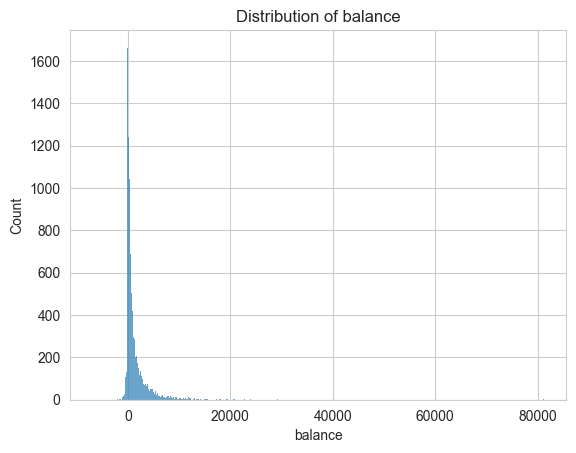

In [12]:
# удалите все выбросы для признака balance
# смотрим распределение признака
ax = sns.histplot(df, x='balance')
plt.title('Distribution of balance')
plt.show()

In [13]:
def outliers_iqr(data, feature):
    """
    Возвращает нижнюю и верхную границы -> lower_bound, upper_bound
    Выбросы -> outliers
    Данные без выбросов -> cleaned
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return round(lower_bound, 2), round(upper_bound, 2), outliers, cleaned

lower_bound, upper_bound, outliers, cleaned = outliers_iqr(df, 'balance') # сохраняем работу функции в переменные
print('Границы поиска выбросов по методу Тьюки ({}, {})'.format(lower_bound, upper_bound))
print('Итоговый размер данных: ', cleaned.shape)


Границы поиска выбросов по методу Тьюки (-2241.0, 4063.0)
Итоговый размер данных:  (10105, 17)


## Часть 2:  Разведывательный анализ

### Задание 1

In [14]:
df = cleaned.copy()

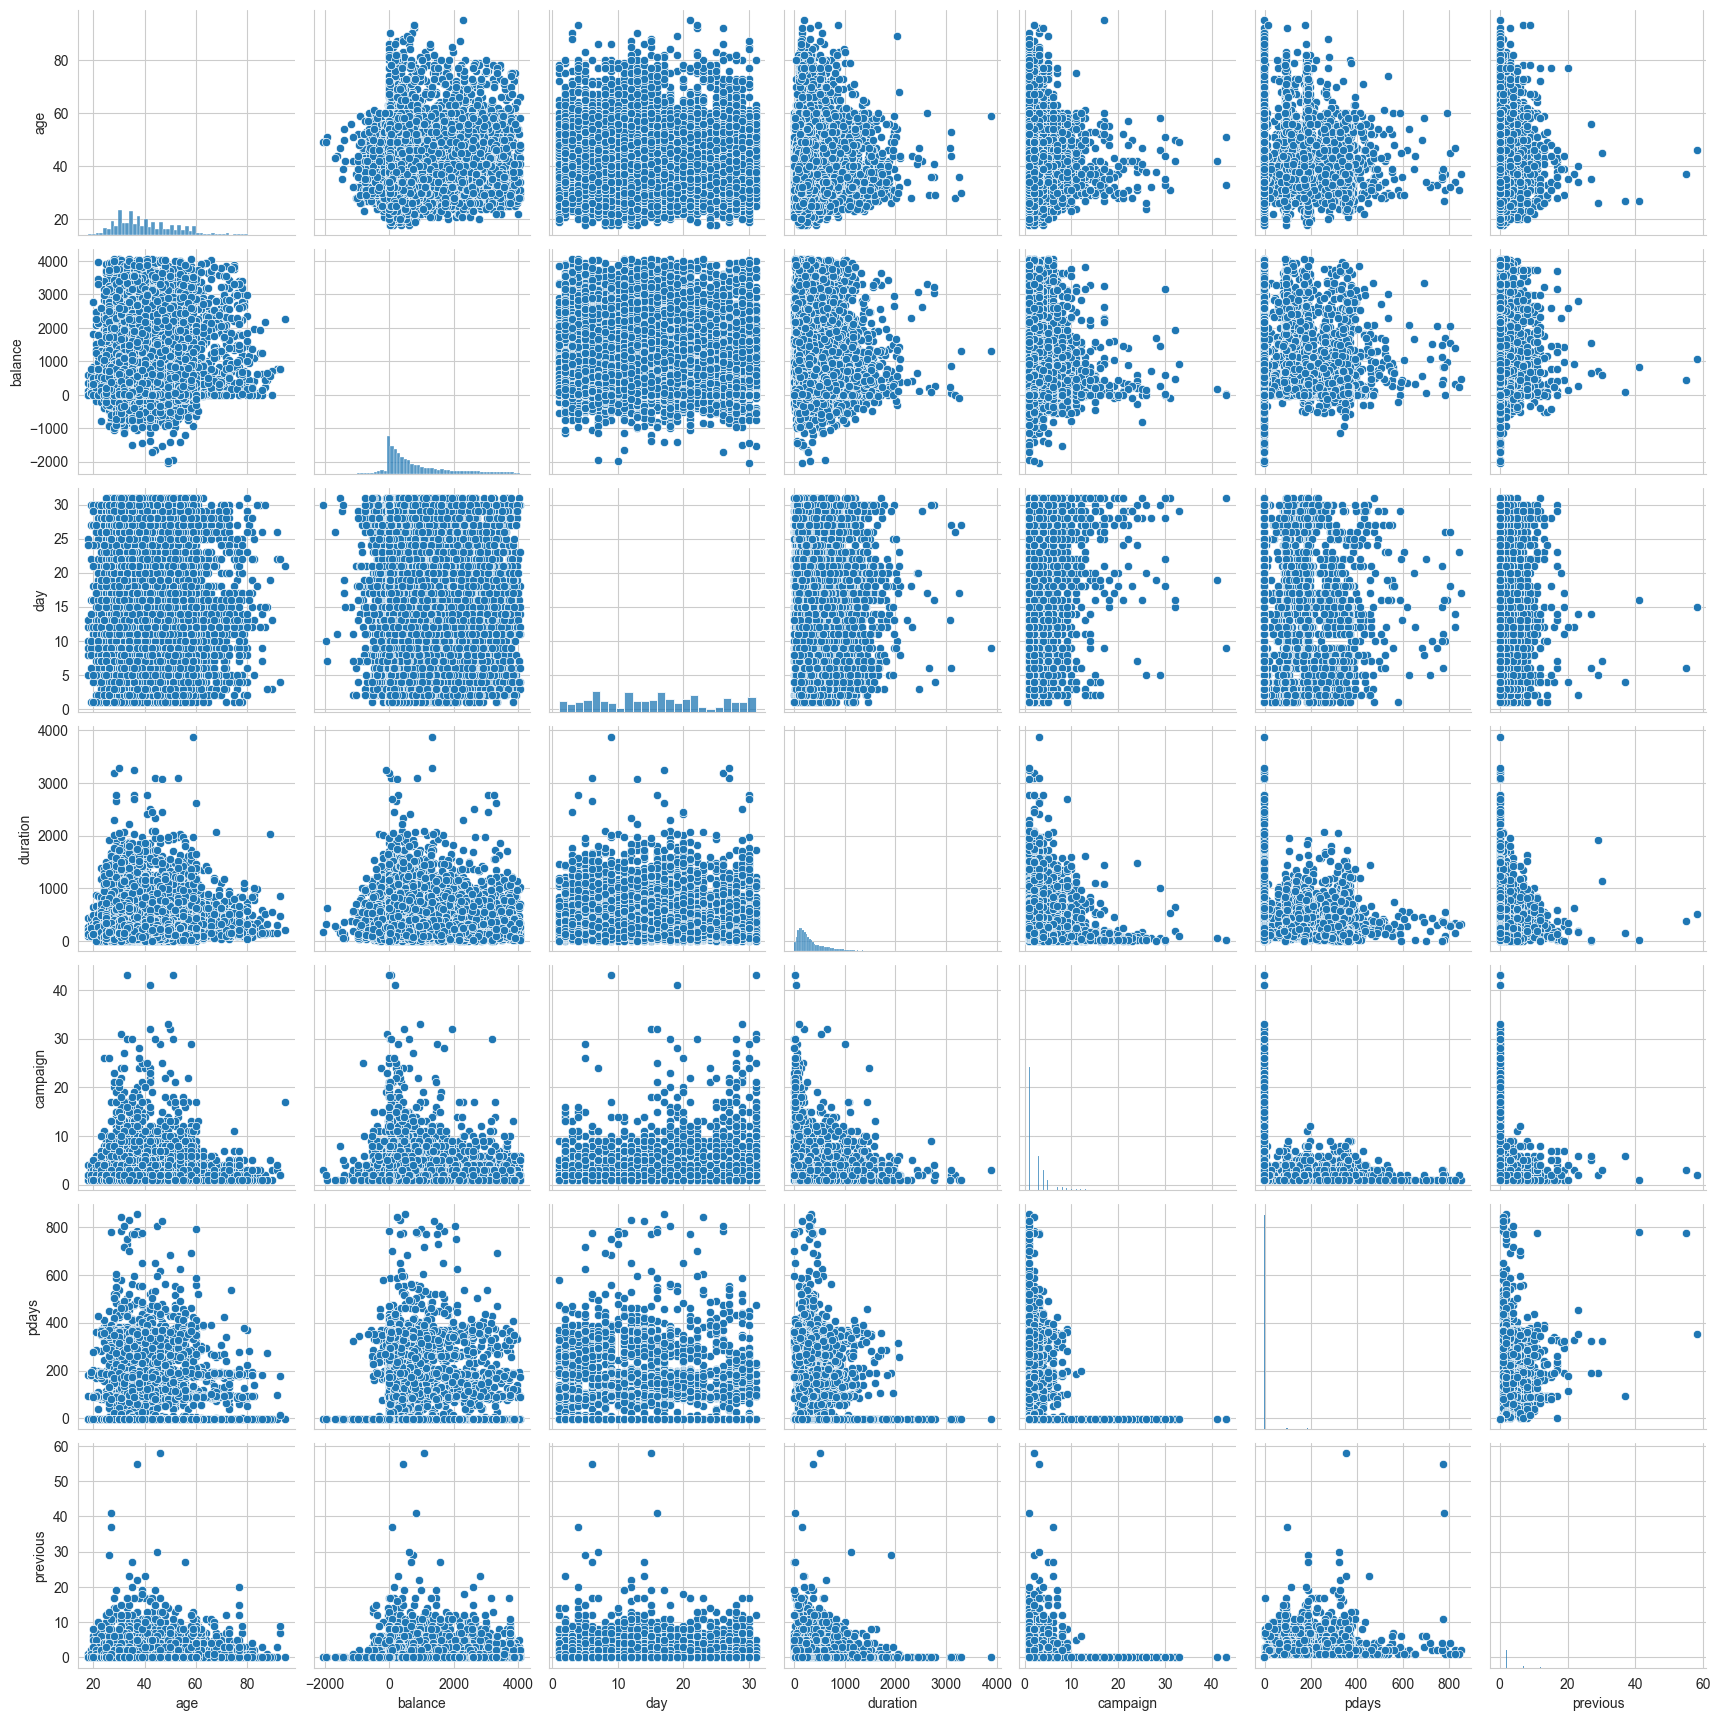

In [15]:
# посмотрим на распределение признаков
sns.pairplot(df);

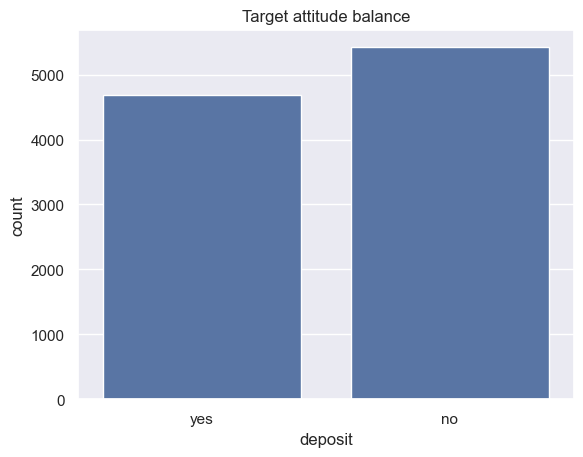

In [16]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.set_theme(style='darkgrid')
ax = sns.countplot(df, x='deposit')
plt.title('Target attitude balance')
plt.show()

In [17]:
df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

### Задания 2 и 3

In [18]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [19]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


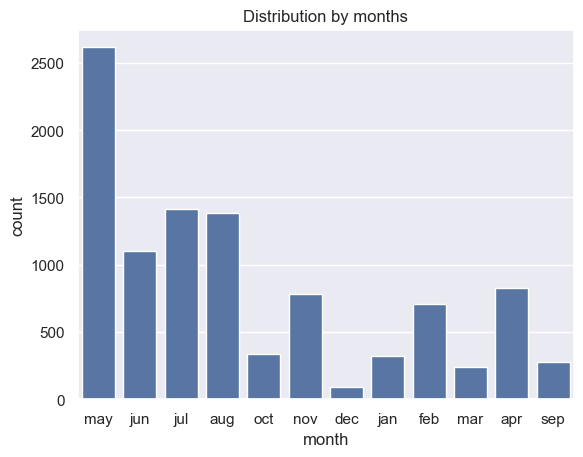

In [20]:
ax = sns.countplot(data=df, x='month')
plt.title('Distribution by months')
plt.show()

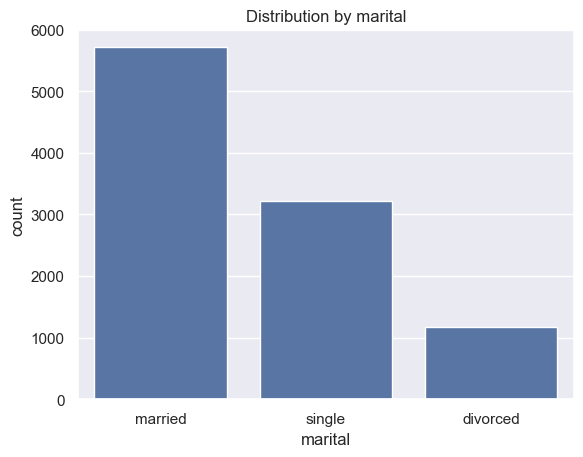

In [21]:
ax = sns.countplot(data=df, x='marital')
plt.title('Distribution by marital')
plt.show()

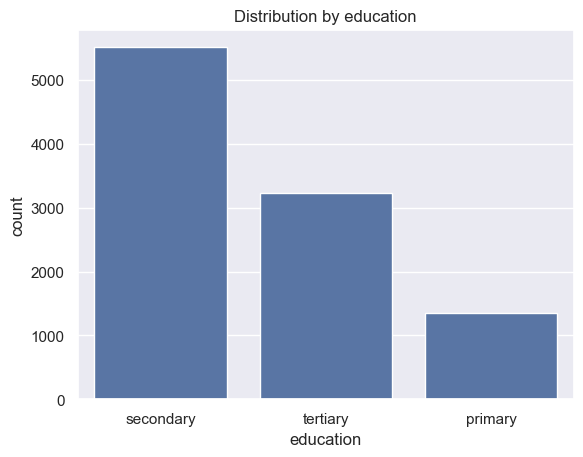

In [22]:
ax = sns.countplot(data=df, x='education')
plt.title('Distribution by education')
plt.show()

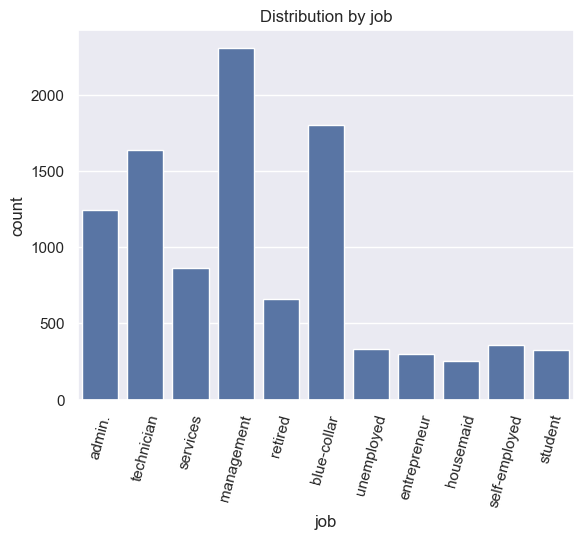

In [23]:
ax = sns.countplot(data=df, x='job')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=75)
plt.title('Distribution by job')
plt.show()

### Задание 6

In [24]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
#df['poutcome'].value_counts()
df.groupby('poutcome')['deposit'].value_counts(normalize=False).unstack()
#types.plot(kind='bar', stacked='True')

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


### Задание 7

In [25]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
for month in np.unique(df.month):
    print(month, round(df[(df.month == month)&(df.deposit == 'no')].shape[0]/df[(df.month == month)].shape[0], 2))

apr 0.38
aug 0.56
dec 0.1
feb 0.46
jan 0.61
jul 0.59
jun 0.55
mar 0.1
may 0.68
nov 0.58
oct 0.19
sep 0.17


### Задание 8, 9 и 10

In [26]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_category'] = pd.cut(df['age'],
    bins=[df['age'].min() - 1, 29, 39, 49, 59, df['age'].max() + 1],
    labels=['<30', '30-40', '40-50', '50-60', '60+'])

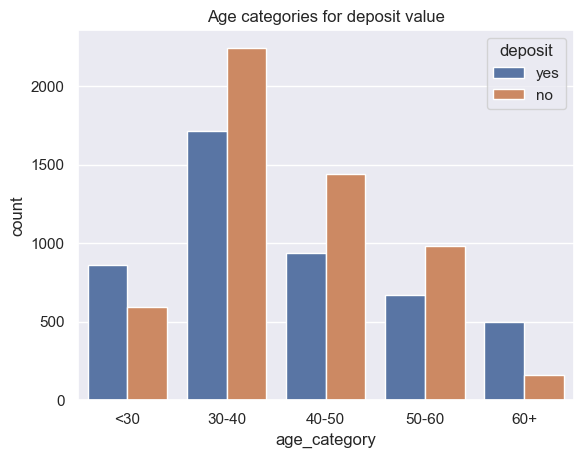

In [27]:
ax = sns.countplot(
    data=df,
    x='age_category',
    hue='deposit',
)
plt.title('Age categories for deposit value')
plt.show()

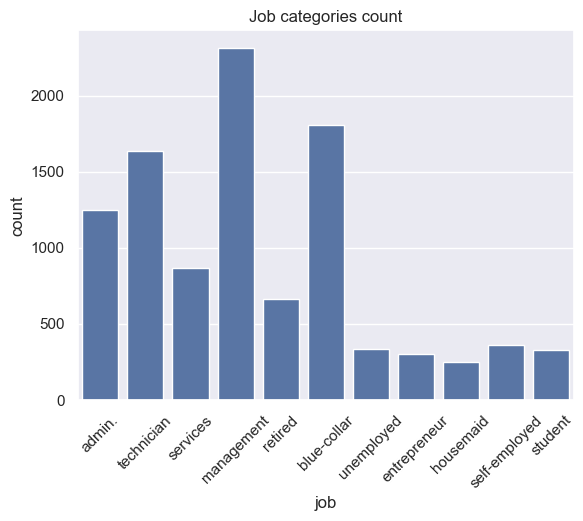

In [28]:
ax = sns.countplot(
    data=df,
    x='job',
    #hue='deposit',
)
plt.title('Job categories count')
plt.xticks(rotation=45)
plt.show()

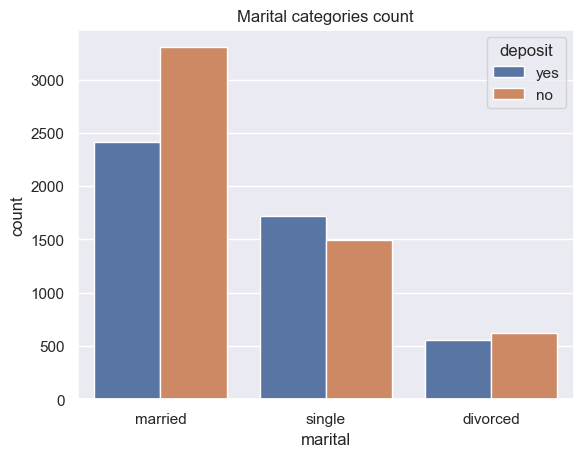

In [29]:
ax = sns.countplot(
    data=df,
    x='marital',
    hue='deposit',
)
plt.title('Marital categories count')
plt.show()

### Задание 11

In [30]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

In [31]:
deposited = df[df['deposit'] == 'yes']
undeposited = df[df['deposit'] == 'no']

ct_deposited = pd.crosstab(
    index=deposited['marital'],
    columns=deposited['education'],
)
ct_undeposited = pd.crosstab(
    index=deposited['marital'],
    columns=deposited['education'],
)

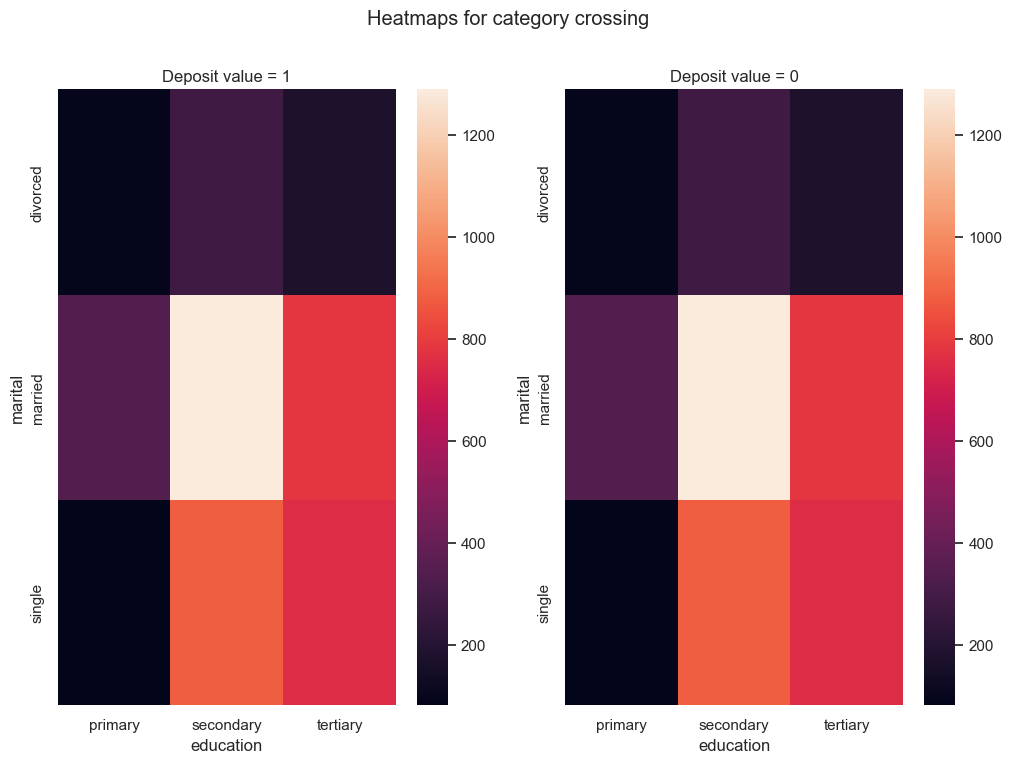

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12,8))
sns.heatmap(ax=axes[0],
    data=ct_deposited
)
axes[0].set_title('Deposit value = 1')
sns.heatmap(
    ax=axes[1],
    data=ct_deposited
)
axes[1].set_title('Deposit value = 0')
fig.suptitle('Heatmaps for category crossing')
plt.show()

## Часть 3: преобразование данных

### Задание 1

In [33]:
# преобразуйте уровни образования
le = LabelEncoder()
le.fit(df['education'])
df['education'] = le.transform(df['education'])
#print(df['education'].sum())
df['education'].sum()

11995

In [34]:
le = LabelEncoder()
le.fit(df['age_category'])
df['age_category'] = le.transform(df['age_category'])
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_category
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2


### Задания 2 и 3

In [35]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

print(round(df['deposit'].std(), 3))

0.499


In [36]:
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

print(round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3))

0.635


### Задание 4

In [37]:
# создайте дамми-переменные
df_dummies = pd.get_dummies(
    data=df,
    columns=['job', 'marital', 'contact', 'month', 'poutcome']
)
# возвращаем оригинальные столбцы для дальнейших заданий
df_task = df_dummies.copy()
df_task['age'] = df['age']
df_task['job'] = df['job']
df_task['marital'] = df['marital']
df_task['month'] = df['month']
df_task['poutcome'] = df['poutcome']
df_task['contact'] = df['contact']

df_task.shape[1]

51

### Задания 5 и 6

In [38]:
corr_matrix = df_dummies.corr()

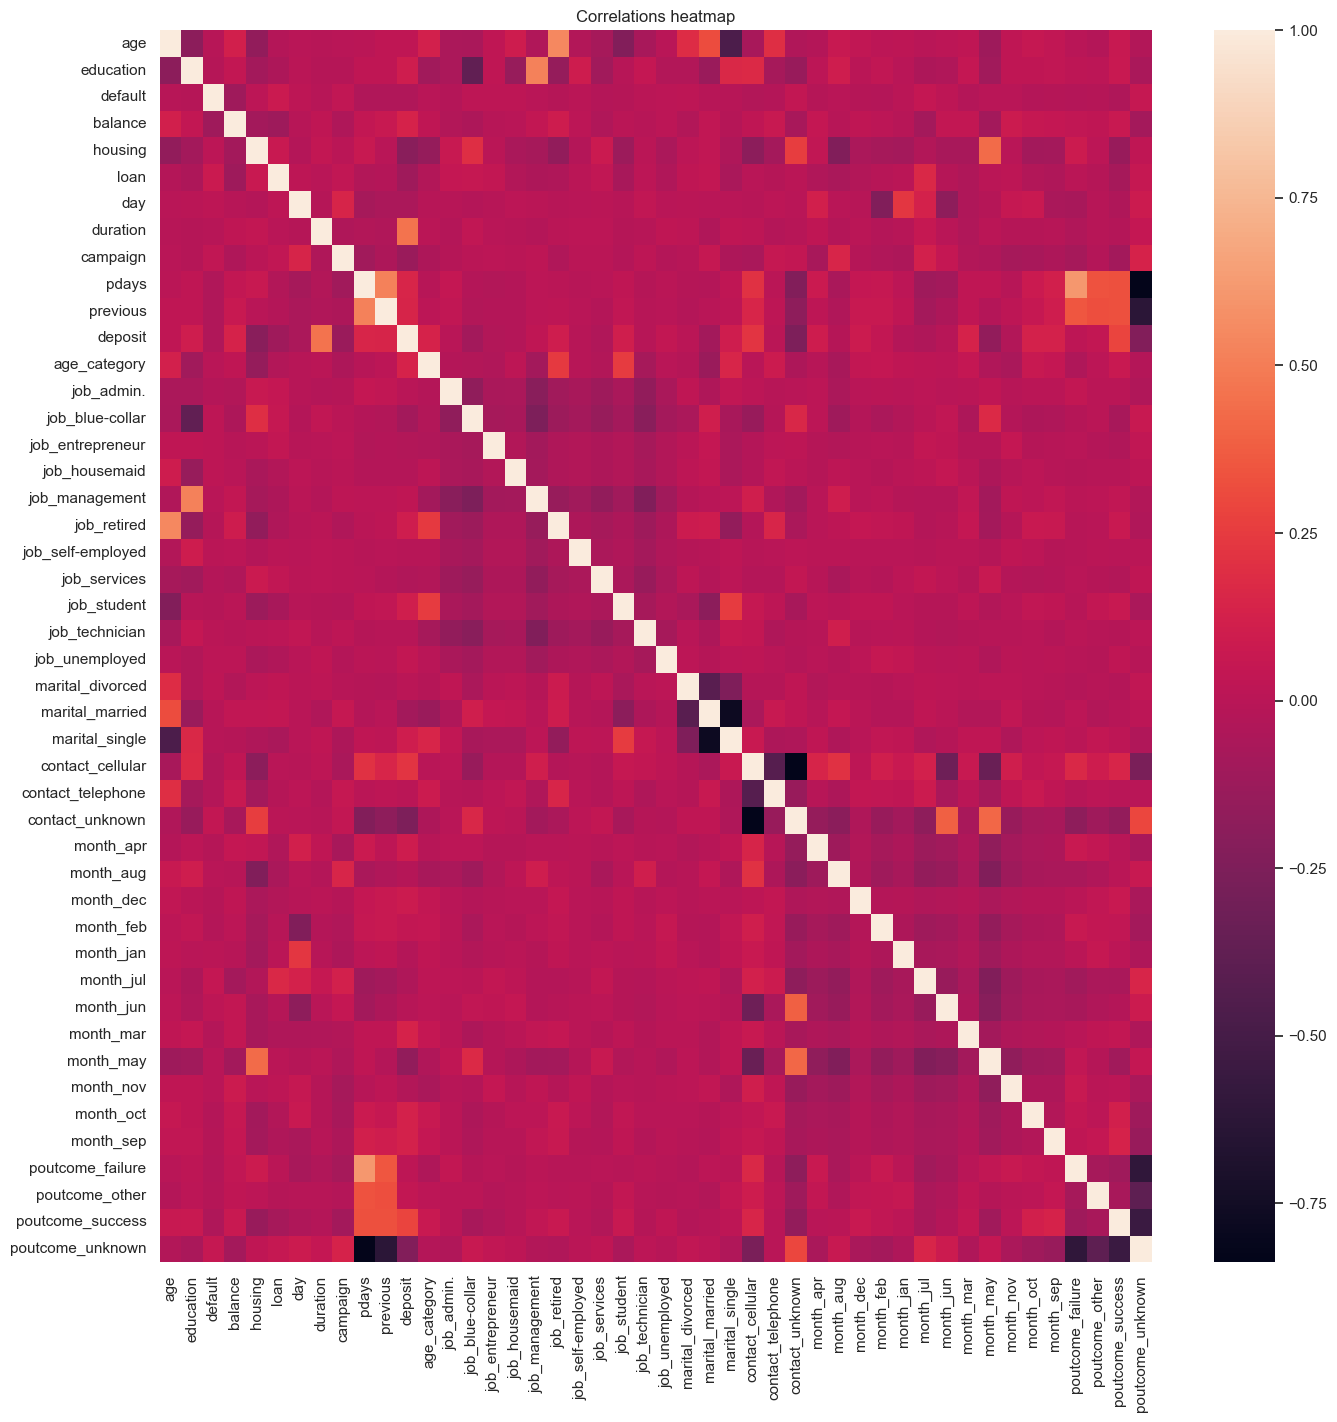

In [39]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig, axes = plt.subplots(1, 1, figsize=(16,16))
sns.heatmap(
    data=corr_matrix,
    annot=False
)
plt.title('Correlations heatmap')
plt.show()

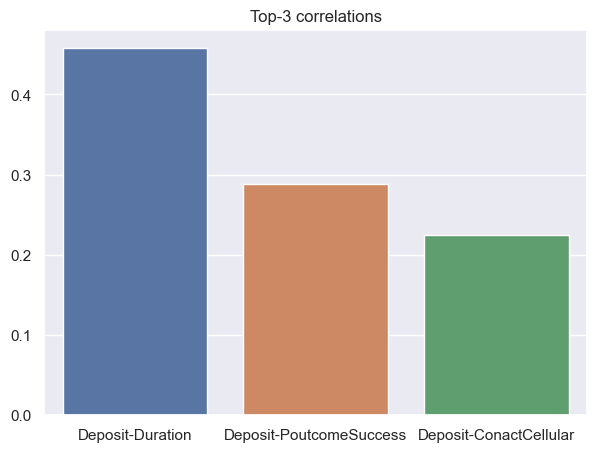

In [40]:
hist_df = pd.DataFrame(
    data=[[corr_matrix.deposit.duration, corr_matrix.deposit.poutcome_success, corr_matrix.deposit.contact_cellular]],
    columns=['Deposit-Duration', 'Deposit-PoutcomeSuccess', 'Deposit-ConactCellular']
)
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
sns.barplot(hist_df)
plt.title('Top-3 correlations')
plt.show()

### Задания 7 и 8

In [41]:
X = df_dummies.drop(['deposit'], axis=1)
y = df_dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [42]:
# рассчитайте необходимые показатели
print('Размер тестовой выборки: ', X_test.shape[0])
print('Среднее значение целевой переменной на тестовой выборке', round(y_test.mean(), 2))

Размер тестовой выборки:  3335
Среднее значение целевой переменной на тестовой выборке 0.46


### Задание 9

In [43]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit_transform(X_train, y_train)
selected = selector.get_feature_names_out().tolist()
selected

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_category',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [44]:
# нормализуйте данные с помощью minmaxsxaler
scaler = MinMaxScaler()
scaler.fit(X_train[selected])
X_train_scaled = scaler.transform(X_train[selected])
X_test_scaled = scaler.transform(X_test[selected])
round(X_test_scaled[:, 0].mean(), 2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [48]:
# обучите логистическую регрессию и рассчитайте метрики качества
lr = linear_model.LogisticRegression(
    solver='sag', 
    max_iter = 1000, 
    random_state=42
)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
print(round(metrics.accuracy_score(y_test, y_pred), 3))

0.805


### Задания 2,3,4

In [68]:
# обучите решающие деревья, настройте максимальную глубину
dtc = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    random_state=42
)

dtc.fit(X_train_scaled, y_train)

y_train_pred = dtc.predict(X_train_scaled)
print('Train', metrics.classification_report(y_train, y_train_pred))

y_test_pred = dtc.predict(X_test_scaled)
print('Test', metrics.classification_report(y_test, y_test_pred))

Train               precision    recall  f1-score   support

           0       0.86      0.83      0.85      3634
           1       0.81      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

Test               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [75]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7],
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(), 
    param_grid=param_grid, 
    cv=3,
    return_train_score=True,
    scoring='f1',
    n_jobs = -1
)
grid_search.fit(X_train_scaled, y_train)
print('Best hyperparams: ', grid_search.best_params_)
y_test_pred = grid_search.predict(X_test_scaled)
print('F1-score on test: ', round(metrics.f1_score(y_test, y_test_pred), 3))

Best hyperparams:  {'max_depth': 7, 'min_samples_split': 2}
F1-score on test:  0.804


In [78]:
dtc = tree.DecisionTreeClassifier(
    max_depth=7,
    min_samples_leaf=2,
    random_state=42
)

dtc.fit(X_train_scaled, y_train)

y_test_pred = dtc.predict(X_test_scaled)
print('Test {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

Test 0.802


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [86]:
# обучите на ваших данных случайный лес
rfc = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rfc.fit(X_train_scaled, y_train)
y_pred_test = rfc.predict(X_test_scaled)
print(round(metrics.f1_score(y_test, y_pred_test), 3))
print(round(metrics.recall_score(y_test, y_pred_test), 3))

0.819
0.835


### Задания 2 и 3

In [87]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gbc = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42,
)
gbc.fit(X_train_scaled, y_train)
y_pred_test = gbc.predict(X_test_scaled)
print(round(metrics.f1_score(y_test, y_pred_test), 3))
print(round(metrics.recall_score(y_test, y_pred_test), 3))

0.817
0.832


### Задание 4

In [91]:
# объедините уже известные вам алгоритмы с помощью стекинга
estimators = [
    (
        'dtc', tree.DecisionTreeClassifier(
            criterion='entropy',
            max_depth=6,
            min_samples_leaf=2,
            random_state=42
        )
    ),
    (
        'lr', linear_model.LogisticRegression(
            solver='sag', 
            random_state=42
        )
    ),
    (
        'gbc', ensemble.GradientBoostingClassifier(
            learning_rate = 0.05,
            n_estimators = 300,
            min_samples_leaf = 5,
            max_depth = 5,
            random_state = 42,
        )
    )
]
stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

stack.fit(X_train_scaled, y_train)
y_train_pred = stack.predict(X_train_scaled)
print('Precision train {:.3f}'.format(metrics.precision_score(y_train, y_train_pred)))

y_test_pred = stack.predict(X_test_scaled)
print('Precision test {:.3f}'.format(metrics.precision_score(y_test, y_test_pred)))

Precision train 0.861
Precision test 0.806


### Задание 5

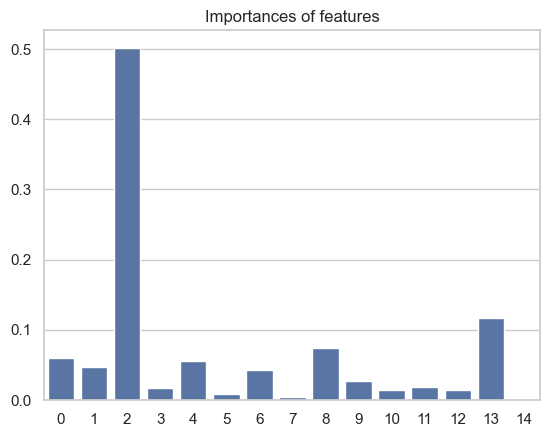

In [99]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
sns.barplot(
    x=[x for x in range(len(gbc.feature_importances_))],
    y=gbc.feature_importances_,
)
plt.title('Importances of features')
plt.show()

### Задания 6,7,8

In [101]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 10)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [102]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-03-11 02:05:15,034] A new study created in memory with name: RandomForestClassifier
[I 2024-03-11 02:05:16,324] Trial 0 finished with value: 0.8559799624295554 and parameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8559799624295554.
[I 2024-03-11 02:05:17,288] Trial 1 finished with value: 0.8528537920250195 and parameters: {'n_estimators': 170, 'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8559799624295554.
[I 2024-03-11 02:05:18,207] Trial 2 finished with value: 0.917189460476788 and parameters: {'n_estimators': 130, 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.917189460476788.
[I 2024-03-11 02:05:19,319] Trial 3 finished with value: 0.858125 and parameters: {'n_estimators': 190, 'max_depth': 14, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.917189460476788.
[I 2024-03-11 02:05:20,411] Trial 4 finished with value: 0.8622848200312989 and parameters: {'n_estimators': 

In [103]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [106]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    **study.best_params, 
    random_state=42
    )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
print('Accuracy score test {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('F1 score test {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Accuracy score test 0.83
F1 score test 0.82
